In [22]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import torch
import torch.nn as nn
import datetime

In [24]:
ilk_zaman = datetime.datetime.now()

In [25]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_neuron):
        super(MLP, self).__init__()
        self.hidden_layer_1 = nn.Linear(input_dim, 100)
        self.hidden_layer_2 = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, output_neuron)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        hidden_1 = self.relu(self.hidden_layer_1(x))
        hidden_2 = self.relu(self.hidden_layer_2(hidden_1))
        output = self.sigmoid(self.output_layer(hidden_2))
        return output

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
from google.colab import drive
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [27]:
folder_path = '/content/drive/MyDrive/dataset'
os.chdir(folder_path)

class MyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.features = self.data.iloc[:, :-1].values.astype(float)
        self.labels = self.data.iloc[:, -1].values.astype(int)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        if self.transform:
            feature = self.transform(feature)
        return torch.tensor(feature), torch.tensor(label)

In [28]:
# Set the seed value
torch.manual_seed(180401046)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the hyperparameters
input_dim = 13
output_neuron = 2
lr = 0.01
batch_size = 16
num_epochs = 60

# Initialize the model and the optimizer
model = MLP(input_dim, output_neuron).to(device)

checkpoint = torch.load('/content/drive/MyDrive/dataset/checkpoint.pt')
model_2 = MLP(input_dim, output_neuron)
model_2.load_state_dict(checkpoint)
model_2.to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [29]:
train_dataset = MyDataset('cure_the_princess_train.csv' )
validation_dataset = MyDataset('cure_the_princess_validation.csv')

# Create the training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [30]:

# Define the lists to store the losses
train_losses = []
validation_losses = []
train_loss = 0.0
validation_loss = 0.0

# Eğitim döngüsü

train_accs = []
val_accs = []

patience = 4
best_validation_loss=None

In [31]:
def train(model, optimizer, criterion, train_loader, validation_loader, num_epochs, train_loss, validation_loss, best_validation_loss, patience):
   
    best_loss = float('inf')
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device).float()
          labels = labels.to(device)
        
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

        
          train_loss += loss.item()

          _,preds = torch.max(outputs, 1)
          running_corrects += torch.sum(preds == labels.data)
          total_train += labels.size(0)

        train_loss = train_loss / len(train_loader)
        train_acc =100. * running_corrects / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        #validation loss ve accuracy hesapla
        validation_loss, val_acc = evaluate(model, criterion, validation_loader, validation_loss, train_loss)
        validation_losses.append(validation_loss)
        val_accs.append(val_acc)
        
        validation_score = validation_loss
        if best_validation_loss is None:
          patience_counter = 0
          best_validation_loss = validation_score
          torch.save(model.state_dict(), "checkpoint.pt")
        elif best_validation_loss < validation_score:
          patience_counter += 1
          print("Earlystopping Patience Counter", patience_counter)
          if patience_counter == patience:
              break
        else:
          best_validation_loss = validation_score
          torch.save(model.state_dict(), "checkpoint.pt")
          patience_counter = 0

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f} - Val Loss: {validation_loss:.4f} - Val Acc: {val_acc:.2f}")

In [32]:
def evaluate(model, criterion, data_loader, validation_loss, train_loss):
    running_loss = 0.0
    running_corrects = 0
    total_val = 0  
    model.eval()
   
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.long())
            
            _, preds = torch.max(outputs, 1)
            validation_loss += loss.item()
            total_val += labels.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
#    train_loss = train_loss / len(train_loader)
    validation_loss = validation_loss / len(validation_loader)
    val_acc = 100. *running_corrects / total_val
    return validation_loss, val_acc


In [33]:
train(model, optimizer, criterion, train_loader, validation_loader, num_epochs, train_loss, validation_loss, best_validation_loss, patience)


Epoch 1/60 - Train Loss: 0.6514 - Train Acc: 64.30 - Val Loss: 0.5759 - Val Acc: 82.17
Epoch 2/60 - Train Loss: 0.5760 - Train Acc: 79.07 - Val Loss: 0.5318 - Val Acc: 87.90
Epoch 3/60 - Train Loss: 0.5270 - Train Acc: 82.27 - Val Loss: 0.5204 - Val Acc: 83.44
Earlystopping Patience Counter 1
Epoch 4/60 - Train Loss: 0.4961 - Train Acc: 84.50 - Val Loss: 0.5211 - Val Acc: 81.85
Earlystopping Patience Counter 2
Epoch 5/60 - Train Loss: 0.4820 - Train Acc: 86.02 - Val Loss: 0.5299 - Val Acc: 79.94
Epoch 6/60 - Train Loss: 0.4658 - Train Acc: 87.30 - Val Loss: 0.4512 - Val Acc: 90.76
Earlystopping Patience Counter 1
Epoch 7/60 - Train Loss: 0.4543 - Train Acc: 87.86 - Val Loss: 0.4851 - Val Acc: 85.99
Earlystopping Patience Counter 2
Epoch 8/60 - Train Loss: 0.4509 - Train Acc: 87.62 - Val Loss: 0.4682 - Val Acc: 87.90
Epoch 9/60 - Train Loss: 0.4400 - Train Acc: 89.54 - Val Loss: 0.4279 - Val Acc: 92.04
Earlystopping Patience Counter 1
Epoch 10/60 - Train Loss: 0.4381 - Train Acc: 88.42 

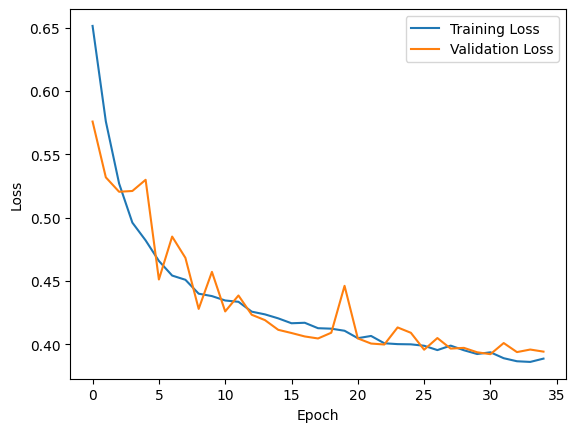

In [34]:
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
test_dataset = MyDataset('cure_the_princess_test.csv' )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [36]:
def evaluate_metrics(model, criterion, data_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true += labels.cpu().numpy().tolist()
            y_pred += preds.cpu().numpy().tolist()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')   

    print(f"Test Accuracy: {accuracy:.4f},Prec Accuracy: {precision:.4f},F1 score: {f1:.4f},Recall score: {recall:.4f}")

    metrics = ['Accuracy', 'Precision', 'F1-score', 'Recall']
    values = [accuracy, precision, f1, recall]

In [37]:
evaluate_metrics(model, criterion, test_loader)

Test Accuracy: 0.9301,Prec Accuracy: 0.9303,F1 score: 0.9300,Recall score: 0.9301


In [38]:
evaluate_metrics(model_2, criterion, test_loader)

Test Accuracy: 0.9236,Prec Accuracy: 0.9237,F1 score: 0.9236,Recall score: 0.9236


In [39]:
son_zaman = datetime.datetime.now()
print(f"Geçen süre {son_zaman-ilk_zaman} device {device}")


Geçen süre 0:00:07.214633 device cuda
